In [3]:
import tensorflow as tf
import tensorflow_io as tfio
import os
import matplotlib.pyplot as plt

print(tf.__version__)
print(tfio.__version__)

2.11.0
0.28.0


In [60]:
CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-0.wav')
NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [61]:
def load_wav_16k_mono(filepath):
        file = tf.io.read_file(filepath)
        wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
        wav = tf.squeeze(wav)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)
        wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
        return wav

In [62]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

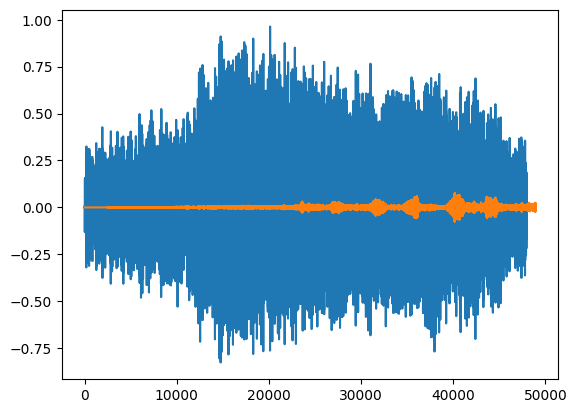

In [63]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

In [64]:
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')

In [ ]:
pos = tf.data.Dataset.list_files(POS + '\*.wav')
neg = tf.data.Dataset.list_files(NEG +'\*.wav')


<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [97]:
# pos.as_numpy_iterator().next()
neg.as_numpy_iterator().next()

b'data\\Parsed_Not_Capuchinbird_Clips\\Crickets-chirping-at-night-10.wav'

In [98]:

# assigning a label
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [99]:
lengths = []
for file in os.listdir(POS):
        tensor_wave = load_wav_16k_mono(os.path.join(POS, file))
        lengths.append(len(tensor_wave))

In [100]:
def preprocess(filepath, label):
        wav = load_wav_16k_mono(filepath)
        wav = wav[:48000]
        padding_zeros = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
        wav = tf.concat([padding_zeros, wav], 0)

        spectogram = tf.signal.stft(wav, frame_length = 320, frame_step = 32)
        spectogram = tf.abs(spectogram)
        spectogram = tf.expand_dims(spectogram, 2)
        return spectogram, label

In [101]:
wav = load_wav_16k_mono(CAPUCHIN_FILE)

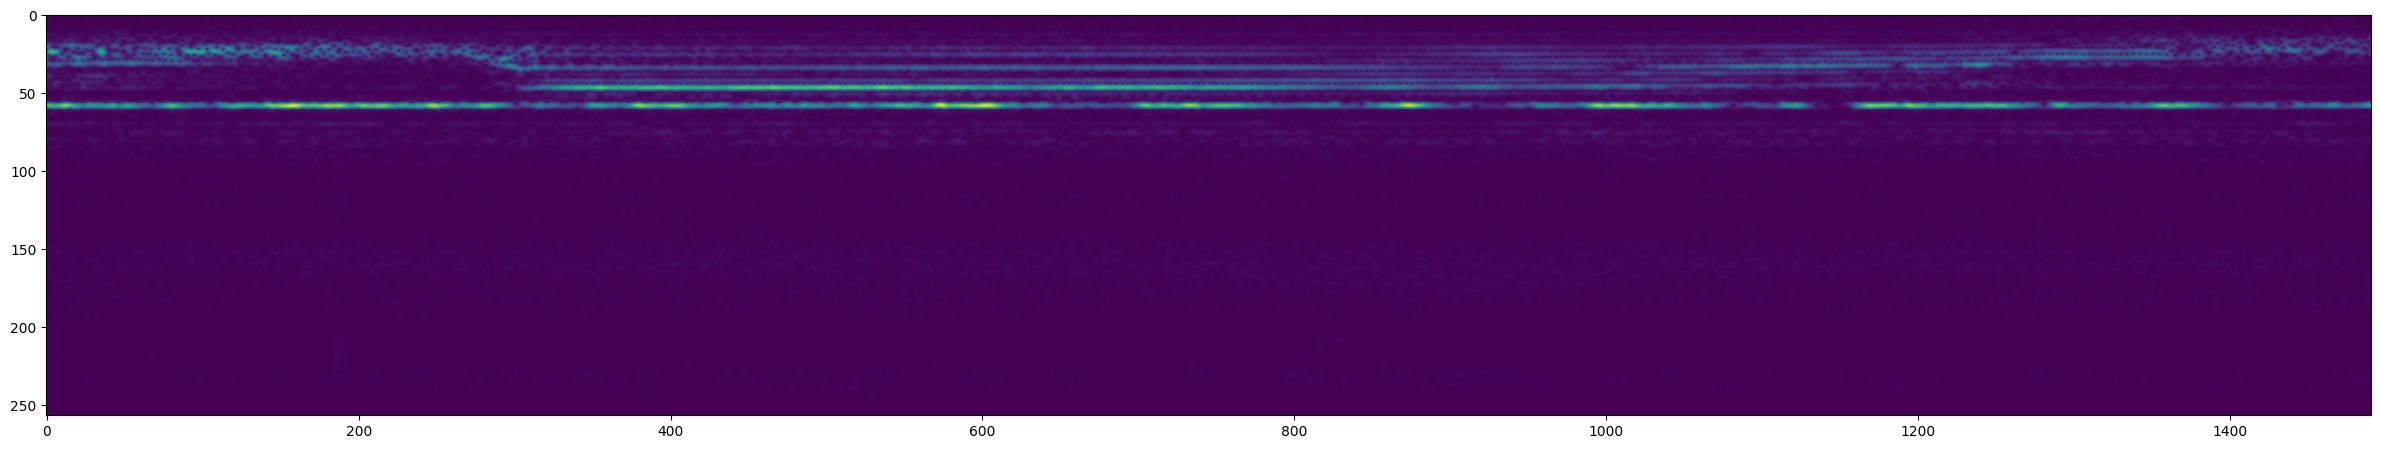

In [102]:
filepath, label = positives.shuffle(1000).as_numpy_iterator().next()
spectogram, label = preprocess(filepath, label)

spectogram = tf.transpose(spectogram)
plt.figure(figsize=(30,20)) 
plt.imshow(spectogram[0])
plt.show()

In [103]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(1000)
data = data.batch(16)
data = data.prefetch(8)

In [113]:
split = int(len(data) * 0.8)
train = data.take(split)
test = data.skip(split).take(len(data)-split)

In [119]:
samples, labels = train.as_numpy_iterator().next()
samples.shape

(16, 1491, 257, 1)

In [118]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

In [122]:
model = Sequential()

model.add(Conv2D(4, (3,3), activation='relu', input_shape=(1291,257,1)))
model.add(Conv2D(4, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [123]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1289, 255, 4)      40        
                                                                 
 conv2d_3 (Conv2D)           (None, 1287, 253, 4)      148       
                                                                 
 flatten_1 (Flatten)         (None, 1302444)           0         
                                                                 
 dense_2 (Dense)             (None, 16)                20839120  
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 20,839,325
Trainable params: 20,839,325
Non-trainable params: 0
_________________________________________________________________


In [ ]:
hist = model.fit(train, epochs=5, validation_data=test)